# Loading libraries

In [99]:
import pandas as pd 
import numpy as np
import os
import glob
import darts
from darts import TimeSeries
from statsmodels.tsa.stattools import adfuller

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score


from darts.models.forecasting.arima import ARIMA
from darts.dataprocessing.transformers.scaler import Scaler




# Helping Functions 


In [100]:

def plot_scatter(df):
    os.makedirs('../plots',exist_ok=True)
    saturday_Df = df[df['day_of_week']==5]
    sunday_Df = df[df['day_of_week']==6]
    friday_Df = df[df['day_of_week']==4]
    thursday_Df = df[df['day_of_week']==3]
    wednesday_Df = df[df['day_of_week']==2]
    Tuesday_Df = df[df['day_of_week']==1]
    monday_Df = df[df['day_of_week']==0]
    fig = make_subplots()
                        
    
    fig.add_trace(go.Scatter(x=df['date'], y=df['order_id'], mode='markers+lines',name='Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=saturday_Df['date'], y=saturday_Df['order_id'], mode='markers',name='-Saturday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=sunday_Df['date'], y=sunday_Df['order_id'], mode='markers',name='-Sunday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=friday_Df['date'], y=friday_Df['order_id'], mode='markers',name='-friday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=thursday_Df['date'], y=thursday_Df['order_id'], mode='markers',name='-Thursday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=wednesday_Df['date'], y=wednesday_Df['order_id'], mode='markers',name='-Wednesday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=Tuesday_Df['date'], y=Tuesday_Df['order_id'], mode='markers',name='-Tuesday-Quantity'),row=1,col=1)
    fig.add_trace(go.Scatter(x=monday_Df['date'], y=monday_Df['order_id'], mode='markers',name='-Monday-Quantity'),row=1,col=1)
    
    fig.update_layout(
        title='Scatter Plot of Order ID',
        height=600,
        width=1800,
        font_size=14
    )
    fig.update_yaxes(title_text='Quantity', row=1, col=1)
    fig.update_yaxes(title_text='Revenue', row=2, col=1)
    fig.show()
    # fig.write_html(f'../plots/{sku_id}_{region_id}.html')
    
def calculate_smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE) given actual and predicted values.

    Parameters:
    actual (list or array): The actual (true) values.
    predicted (list or array): The predicted values.

    Returns:
    smape (float): The SMAPE value.
    """
    n = len(actual)
    sum_smape = sum(2 * abs(a - p) / (abs(a) + abs(p)) for a, p in zip(actual, predicted))
    smape = (1 / n) * sum_smape * 100
    return smape

def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    smape = calculate_smape(actual, predicted)
    r2 = r2_score(actual, predicted)

    medae = median_absolute_error(actual, predicted)

    # Mean Squared Logarithmic Error (MSLE)
    msle = mean_squared_log_error(actual, predicted)
    
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MSE': mse,
        'SMAPE':smape,
        'R2':r2,
        'MEDEA':medae,
        'MSLE':msle,
        
    }
    
    return metrics



# Loading data

In [101]:
os.makedirs('../processedData/Iteration_03', exist_ok=True)

fileName = '../RawData/Sales Forecast_NEW2.xlsx'
df = pd.read_excel(fileName,sheet_name='NEW_DATA')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.sort_values(['date'],inplace=True)
df.reset_index(inplace=True,drop=True)
df.to_csv('../processedData/Iteration_03/sorted_Sales_Forecast_dataset.csv',index=False)
df =  df[['date','order_id']]
df.to_csv('../processedData/Iteration_03/date_order_sales_forecast_dataset.csv',index=False)


In [102]:
df.head()

,date,order_id
0,2022-01-01,115
1,2022-01-01,19
2,2022-01-02,187
3,2022-01-02,24
4,2022-01-03,38


In [103]:
df = df.groupby('date')['order_id'].sum().reset_index()
df.to_csv('../processedData/Iteration_03/date_order_id_sales_forecast_cleaned.csv',index=False)

In [104]:
df['year'] = df['date'].dt.year
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_of_week
df['day_name'] = df['date'].dt.strftime('%A')


In [105]:
df.head()

,date,order_id,year,day_of_month,month,day_of_week,day_name
0,2022-01-01,134,2022,1,1,5,Saturday
1,2022-01-02,211,2022,2,1,6,Sunday
2,2022-01-03,279,2022,3,1,0,Monday
3,2022-01-04,288,2022,4,1,1,Tuesday
4,2022-01-05,247,2022,5,1,2,Wednesday


In [106]:
plot_scatter(df)

# stationary Tesst

In [107]:
def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")
adfuller_test(df['order_id'])

ADF Test Statistic : -6.198446460410652
p-value : 5.886750247328974e-08
#Lags Used : 16
Number of Observations Used : 582
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

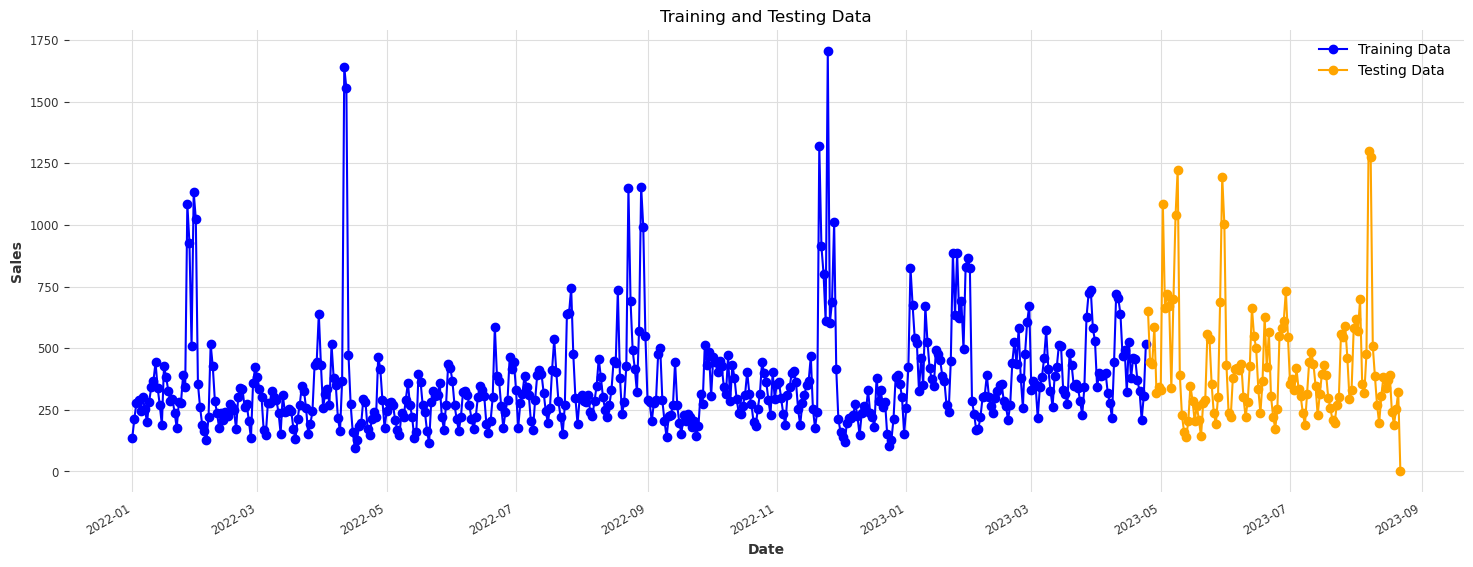

In [108]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(df, "date", "order_id", freq='1D', fill_missing_dates=True, fillna_value=0)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label='Training Data', color='blue', linewidth=1.5, marker='o')
test_series.plot(label='Testing Data', color='orange', linewidth=1.5, marker='o')

# Add title and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


## Inspect Seasonality

In [109]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

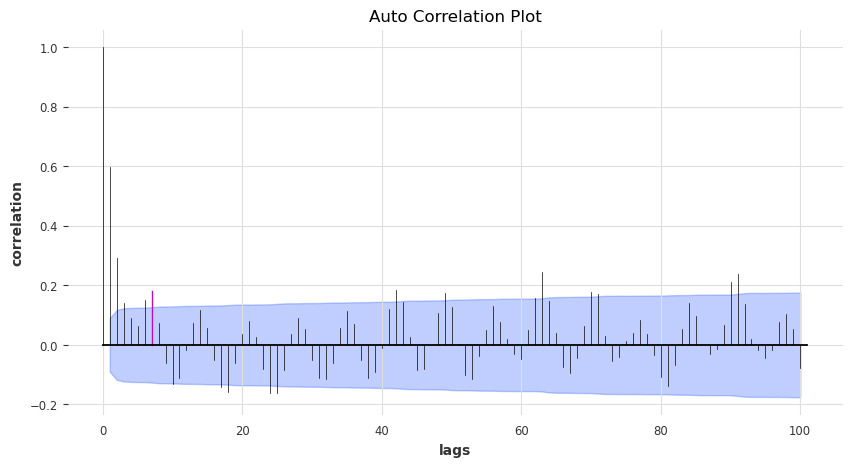

In [110]:
from darts.utils.statistics import plot_acf,plot_pacf


plot_acf(train_series, m=7, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)
plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

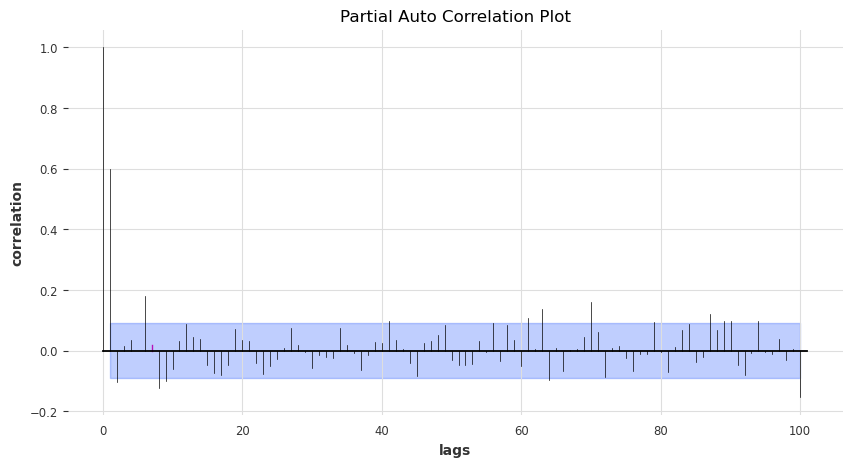

In [111]:
from darts.utils.statistics import plot_acf,plot_pacf
plot_pacf(train_series, m=7, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot')
plt.show()

# SARIMA Model

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



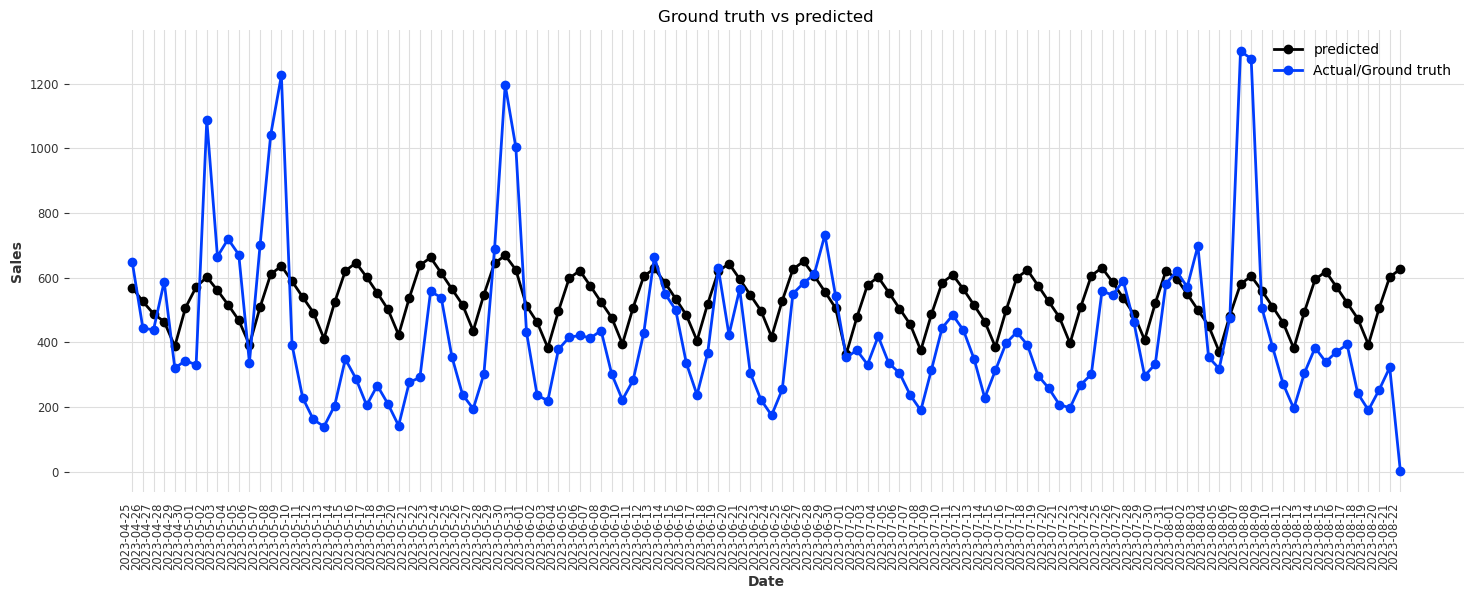

In [112]:
sarima_model = ARIMA(
    p=4,
    d=0, 
    q=2, 
    trend='n', 
    random_state=1999,
    seasonal_order=(4,0,2,7),
    add_encoders={
                'cyclic': {'future': ['month']},
                'datetime_attribute': {'future': ['hour', 'dayofweek']},
                'position': {'future': ['relative']},
                'custom': {'future': [lambda idx: (idx.year - 1950) / 50]},
                'transformer': Scaler()
            }
                                            ,
)

sarima_model.fit(train_series)
sarima_model.model.summary()




horizan = 30*4

# summary = arima_model.model.summary()
test_series_ = test_series[0:horizan]
plt.figure(figsize=(18, 6))
forcast_arima = sarima_model.predict(horizan)
sarima_model.predict(horizan).plot(marker='o',label='predicted')
test_series_.plot(marker='o',label='Actual/Ground truth')
# Add title and labels
plt.title('Ground truth vs predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(forcast_arima.time_index, forcast_arima.time_index.strftime('%Y-%m-%d'), rotation=90)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


# Model Evaluation

In [115]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Function to predict and evaluate
def predict_and_evaluate(window_size, prediction_horizon, slide_step, test_series, model,result_plot_path ):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1
    
    meta_information_evaluation = {
        'Iterations': [],
        'MAE': [],
        'RMSE': [],
        'MAPE': [],
        'MSE': [],
        'SMAPE':[],
        'R2':[],
        'MEDEA':[],
        'MSLE':[],
        'input_window_size': [],
        'horizon': [],
        'stride': []
    }
    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i:i + window_size]
            ground_truth = test_series[i + window_size:i + window_size + prediction_horizon]
            forecast = model.predict(n=prediction_horizon, series=input_window)
            actual = ground_truth.values().flatten().tolist()
            
            predicted = forecast.values().flatten().tolist()
            metrics = calculate_metrics(actual, predicted)
            
            meta_information_evaluation['Iterations'].append(i)
            meta_information_evaluation['MAE'].append(metrics['MAE'])
            meta_information_evaluation['RMSE'].append(metrics['RMSE'])
            meta_information_evaluation['MAPE'].append(metrics['MAPE'])
            meta_information_evaluation['MSE'].append(metrics['MSE'])
            meta_information_evaluation['input_window_size'].append(window_size)
            meta_information_evaluation['horizon'].append(prediction_horizon)
            meta_information_evaluation['stride'].append(slide_step)
            
            meta_information_evaluation['SMAPE'].append(metrics['SMAPE'])
            meta_information_evaluation['R2'].append(metrics['R2'])
            meta_information_evaluation['MEDEA'].append(metrics['MEDEA'])
            meta_information_evaluation['MSLE'].append(metrics['MSLE'])
        
            bypass_information = {
                'slide_step':slide_step,
                'window_size':window_size,
                'horizon':prediction_horizon,            
            }
            create_plots(input_window,forecast,ground_truth,result_plot_path,bypass_information,metrics)

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)
        
        return evalaution_df
    
    except Exception as e:
        print('Error Occurred in fuction predict_and_evaluate():', e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)
        
        return evalaution_df


# Function to create plots
def create_plots(input_window, forecast, ground_truth,result_plot_path,bypass_information,metrics):
    
    plt.figure(figsize=(30, 10))
    input_window.plot(label='Input Data', marker='o')
    forecast.plot(label='Predicted', marker='o')
    ground_truth.plot(label='Ground Truth', marker='o')
    
    combined_time_index = input_window.time_index.append(forecast.time_index).append(ground_truth.time_index)
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")
    
    smape = np.round(metrics['SMAPE'],2)
    
    cms_prediction = int(np.sum(forecast.values().flatten().tolist()))
    cms_actual = int(np.sum(ground_truth.values().flatten().tolist()))
    

    plt.xticks(combined_time_index, combined_time_index.strftime('%Y-%m-%d'), rotation=90)
    plt.title(f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}\nSmape : {smape}\n Total Number of Orders in Actual : {cms_actual}\n Total Number of Orders in prediction : {cms_prediction}", fontsize=16)
    plt.ylabel('Number of Orders', fontsize=14)
    plt.xlabel('Dates', fontsize=14)
    plt.legend()
    
    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()    
def model_evaluation(model_name,model_object,test_series,FileName):
    
    result_path = f'../ProcessedData/Results/{model_name}/{FileName}'
    result_plot_path = f'../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots'
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_plot_path,exist_ok=True)

        # Set your parameters
    window_sizes = [30, 45, 90]
    prediction_horizons = [15, 30,35]
    slide_steps = [5, 10, 15]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(f'Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}')
                evaluation_df = predict_and_evaluate(window_size, prediction_horizon, slide_step, test_series, model,result_plot_path)
                evaluation_df.to_csv(f'{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv', index=False)
                
                print(f'Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed.')

In [116]:
model_name = 'SARIMA'
FileName = 'Sarima_model'
model_object = sarima_model
test_series = test_series 
model_evaluation(model_name,model_object,test_series,FileName)


Iteration : Window size : 30 Horizan: 15, Stride : 5


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Window_size_30_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 15, Stride : 10


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Window_size_30_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 15, Stride : 15


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Window_size_30_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 5


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Window_size_30_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 10


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Window_size_30_prediction_horizon_30_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 15


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Window_size_30_prediction_horizon_30_slide_step_15 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 5


100%|██████████| 12/12 [00:21<00:00,  1.79s/it]


Window_size_30_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 10


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Window_size_30_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 15


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Window_size_30_prediction_horizon_35_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 5


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Window_size_45_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 10


100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


Window_size_45_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 15


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Window_size_45_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 5


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Window_size_45_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 10


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Window_size_45_prediction_horizon_30_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 15


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Window_size_45_prediction_horizon_30_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 5


100%|██████████| 9/9 [00:22<00:00,  2.46s/it]


Window_size_45_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 10


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Window_size_45_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 15


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Window_size_45_prediction_horizon_35_slide_step_15 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 5


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Window_size_90_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 10


100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


Window_size_90_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 15


100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Window_size_90_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 90 Horizan: 30, Stride : 5


100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Window_size_90_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 30, Stride : 10


  0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
import pandas as pd
import glob

def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        'window_size': [],
        'horizan': [],
        'stride': [],
        'AVG_MAE': [],
        'AVG_MSE': [],
        'AVG_RMSE': [],
        'AVG_MAPE': [],
        'AVG_SMAPE':[],
        'AVG_R2': [],
        'AVG_MEDEA':[],
        'AVG_MSLE' :[]
    }
    
    paths = glob.glob(file_pattern)
    
    for path in paths:
        window_size = path.split('/')[-1].split('_')[2]
        horizan = path.split('/')[-1].split('_')[4]
        stride = path.split('/')[-1].split('_')[6].split('.')[0]

        df = pd.read_csv(path)
        eval_dict['window_size'].append(window_size)
        eval_dict['horizan'].append(horizan)
        eval_dict['stride'].append(stride)

        eval_dict['AVG_MAE'].append(df['MAE'].mean())
        eval_dict['AVG_MSE'].append(df['MSE'].mean())
        eval_dict['AVG_RMSE'].append(df['RMSE'].mean())
        eval_dict['AVG_MAPE'].append(df['MAPE'].mean())
        
        eval_dict['AVG_SMAPE'].append(df['SMAPE'].mean())
        eval_dict['AVG_R2'].append(df['R2'].mean())
        eval_dict['AVG_MEDEA'].append(df['MEDEA'].mean())
        eval_dict['AVG_MSLE'].append(df['MSLE'].mean())
    
    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(['window_size', 'horizan', 'stride'], inplace=True, ascending=True)
    
    return eval_df

# Example usage
file_pattern = '../ProcessedData/Results/SARIMA/Sarima_model/*.csv'
result_df = aggregate_evaluation_results(file_pattern)
# result_df
for name ,groupDf in result_df.groupby('window_size'):
    display(groupDf)


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE,AVG_SMAPE,AVG_R2,AVG_MEDEA,AVG_MSLE
5,30,15,10,120.923134,36493.432278,166.004039,27.564071,27.011591,0.247082,102.697509,0.124643
15,30,15,15,150.436718,42348.230256,187.128062,620.859109,34.989059,0.107300,140.537994,0.510370
23,30,15,5,129.936877,36860.852641,169.461889,250.244358,29.583057,0.222461,112.969741,0.262210
14,30,30,10,117.138349,32185.819661,164.871832,219.356019,27.719561,0.249314,86.885184,0.253985
26,30,30,15,124.489049,36087.693455,179.037309,296.193479,29.321925,0.205102,92.515398,0.316448
10,30,30,5,116.864635,30764.867301,163.509477,131.501644,27.510916,0.238956,93.034981,0.190257
16,30,35,10,109.983648,26386.855477,155.031434,28.253932,26.120211,0.273554,86.057887,0.109342
2,30,35,15,113.268360,28195.537887,158.977396,28.234888,26.710865,0.290725,92.685437,0.113810
3,30,35,5,113.755187,28613.225282,160.083637,129.360957,27.055146,0.263783,92.225905,0.181350


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE,AVG_SMAPE,AVG_R2,AVG_MEDEA,AVG_MSLE
8,45,15,10,132.207070,35445.691797,165.079966,530.601040,31.025171,0.218044,115.627059,0.427898
20,45,15,15,143.641105,38879.056956,177.312781,731.491824,34.187738,0.084561,129.453899,0.567437
18,45,15,5,127.169570,36602.759035,167.570470,298.027268,29.163534,0.201195,104.897955,0.287621
19,45,30,10,111.256747,28249.824184,157.669582,27.118836,26.131238,0.236581,86.213278,0.106216
11,45,30,15,117.524971,34850.308546,174.555068,385.095810,27.935225,0.202264,77.654619,0.357157
9,45,30,5,112.077908,30614.545345,161.768671,170.029761,26.377827,0.244672,83.630357,0.204098
4,45,35,10,113.238858,30162.457843,162.126147,279.271884,27.144084,0.255469,87.440854,0.273537
7,45,35,15,103.970936,25651.542635,151.105921,24.941210,24.636073,0.280293,72.819536,0.097753
13,45,35,5,110.423964,28994.081802,161.002953,166.650069,26.206547,0.239819,83.994384,0.197221


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE,AVG_SMAPE,AVG_R2,AVG_MEDEA,AVG_MSLE
12,90,15,10,171.068305,79567.436824,281.741525,26.383960,30.428074,-0.029457,98.415875,0.171441
25,90,15,15,206.459923,70681.722327,265.851758,1880.789729,45.879975,-0.099992,179.982003,1.275180
24,90,15,5,188.506585,80446.214931,283.082046,952.733978,36.857950,0.021979,123.165103,0.719156
1,90,30,10,160.653400,67797.630090,260.379780,1899.970048,34.846154,0.065229,86.631749,1.203959
22,90,30,15,160.653400,67797.630090,260.379780,1899.970048,34.846154,0.065229,86.631749,1.203959
17,90,30,5,160.653400,67797.630090,260.379780,1899.970048,34.846154,0.065229,86.631749,1.203959
